In [17]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [18]:
import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='serif')

from tqdm.notebook import tqdm

import torch
import torch.distributions as dist
import zuko

from geobed import BED_discrete
from geobed.fwd_collection.avo import *

In [19]:
# model prior
a_1_model = torch.tensor(2750.0)
d_model   = torch.tensor(500.0 )

a_2_mean = torch.tensor([3750.0])
a_2_std = torch.tensor([300.0])
a_2_prior_dist = dist.Independent(dist.Normal(a_2_mean, a_2_std), 1)

# a_2_min = torch.tensor([3000.0])
# a_2_max = torch.tensor([4500.0])
# a_2_prior_dist = dist.Independent(dist.Uniform(a_2_min, a_2_max), 1)

n_prior = int(2e6)

a_2_prior_samples = a_2_prior_dist.sample((n_prior,))

In [20]:
def forward_function(offset, a_2):
    return calculate_avo(offset, a_1_model, a_2, d_model)

In [21]:
def data_likelihood(samples, **kwargs):
    
    std_data = 0.05
    data_likelihood = dist.Independent(dist.Normal(samples, torch.tensor(std_data)), 1)
    
    return data_likelihood

In [22]:
n_design_points = 200
offsets      = torch.linspace(1.0, 3500.0, n_design_points)

In [23]:
# import os
# import h5py

# filename_core = 'avo_data_gaussian_global_optimum'
# filename = f"data/{filename_core}_{n_prior}_{n_design_points}.h5"

# if os.path.isfile(filename):
#     print('loading data from file')
#     with h5py.File(filename, 'r') as f:
#         # data = f['data'][:]
#         a_2_prior_samples = f['prior'][:]
#     # tt_array = torch.from_numpy(tt_array)
#     a_2_prior_samples = torch.from_numpy(a_2_prior_samples)
# else:
#     data = forward_function(offsets, a_2_prior_samples)[:, :, None]

#     with h5py.File(filename, 'w') as f:
#         f.create_dataset('data', data=data)
#         f.create_dataset('prior', data=a_2_prior_samples.numpy())
        
#     print('dimensions: (n_prior, n_design, data_dim)')
#     print(data.shape, data.dtype,  '\n')

#     # quick check if all calculations succeded and the data is ok
#     print(np.count_nonzero(data))
#     print(np.count_nonzero(np.isnan(data)))


In [24]:
design_names = [str(i) for i in range(n_design_points)]

design_dicts = {}

def constructor_1to1_design(self, name_list, n_samples):
        
    name_list = list(dict.fromkeys(name_list)) # remove duplicates 
    # list(set(name_list)) destroys the order of the list
    design_dicts_list = [self.design_dicts[n] for n in name_list]
    
    data = torch.zeros((n_samples, len(name_list), 2))

    for i, d_meta in enumerate(design_dicts_list):
        data[:, i, :] = d_meta['forward_function'](d_meta['offset'], self.prior_samples[:n_samples])

    return data.flatten(start_dim=-2)

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'offset': offsets[i], 'forward_function': forward_function, 'dataset': 'data', 'cost': 1.0,}

torch.manual_seed(0)
prior_samples = a_2_prior_dist.sample((int(2e7),))

BED_class = BED_discrete(design_dicts, data_likelihood, prior_samples=prior_samples, prior_dist=a_2_prior_dist,
                         design2data=constructor_1to1_design)

In [25]:
from itertools import product

global_design_grid = list(product(design_names, design_names))

print(len(global_design_grid))

40000


In [26]:
eig, info = BED_class.calculate_eig_list(
     global_design_grid,
     'nmc',
     method_kwargs={'N':int(1e4), 'M':int(1e4), 'reuse_M_samples':True},
     num_workers=10,
     progress_bar=True,
     random_seed=0,
     parallel_method='joblib',
     filename='data/avo_gaussian_2rec_global_optimum_eig.pkl',   
)

Loading eig values from data/avo_gaussian_2rec_global_optimum_eig.pkl


In [27]:
eig = np.array(eig)
eig_grid = eig.reshape((n_design_points, n_design_points))

In [28]:
import pickle
import os
import numpy as np

filename = 'data/avo_onestep_2rec_results.pkl'

if os.path.exists(filename):
    print(f'Loading eig values from {filename}')
    with open(filename, 'rb') as f:
        results = pickle.load(f)
        
    losses_collection, design_history_collection = zip(*results)

    losses_collection = np.array(losses_collection)
    design_history_collection = np.array(design_history_collection)
else:
    print(f'File {filename} does not exist. Calculate in other file.')


Loading eig values from data/avo_onestep_2rec_results.pkl


In [29]:
print(design_history_collection.shape)

(100, 100000, 2)


In [30]:
# design_history_collection_sorted = np.sort(design_history_collection, axis=-1)

# print(design_history_collection_sorted.shape)

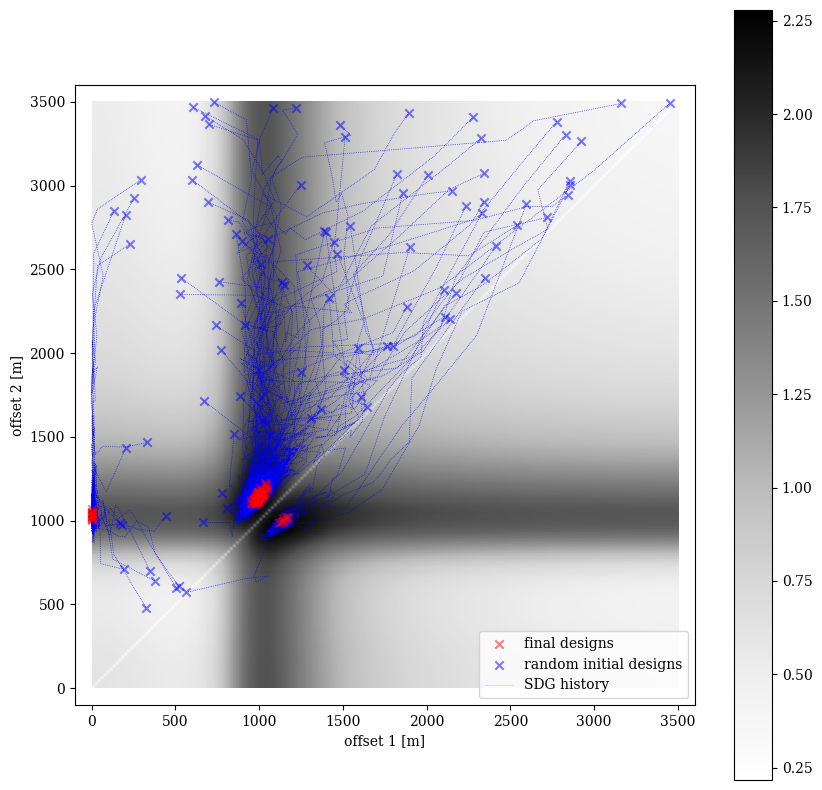

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(eig_grid,
          origin='lower',
          extent=[1, 3500, 1, 3500],
        #   alpha=0.8,
          cmap='Greys')

ax.scatter(design_history_collection[:, -1, 0].T,
           design_history_collection[:, -1, 1].T,
           alpha=0.5,
           marker='x',
           color='r',
           clip_on=False,
           label='final designs',
           zorder=10)

ax.plot(design_history_collection[:, ::1000, 0].T, design_history_collection[:, ::1000, 1].T,
        color='b', alpha=1.0, linestyle=':', linewidth=0.5, marker='None', clip_on=False, )

ax.scatter(design_history_collection[:, 0, 0].T,
           design_history_collection[:, 0, 1].T,
           alpha=0.5,
           marker='x',
           color='b',
           clip_on=False,
           label='random initial designs')

ax.plot([], [],
        color='b', alpha=0.2, linewidth=0.5, marker='None', clip_on=False, label='SDG history')

ax.set_xlim(-100, 3600)
ax.set_ylim(-100, 3600)

ax.set_xlabel('offset 1 [m]')
ax.set_ylabel('offset 2 [m]')

ax.legend(loc='lower right')

plt.colorbar(im)

fig.savefig('figures/avo_gaussian_2rec_global_optimum_eig.pdf', bbox_inches='tight',
            dpi=120, transparent=True)
fig.savefig('figures/avo_gaussian_2rec_global_optimum_eig.png', bbox_inches='tight',
            dpi=120, transparent=True)

plt.show()

In [32]:
print(eig_grid.max())
print(eig_grid[0, :].max())

2.2786093
1.7577678
